## Задание 7.
#### Исполнитель: Гребенькова Ольга
Повторить эксперимент по удалению параметров из статьи Graves (график 4). Выборка: MNIST, Fashion-MNIST, CIFAR-10 или любая другая, используемая в DL. Модель: произвольная нейросеть. Вариационное распределение: нормальное с диагональной матрицей ковариаций.




### Импортируем все нужные библиотеки

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn.init as init
import math

In [2]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

### Инициализация параметров

In [36]:
init_log_sigma = -2.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 15 #количество эпох
hidden_num = 20
batch_size = 256

In [37]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)


### Функция обучения

In [38]:
def train(net, loss_fn, optimizer):
    losses = []
    for x,y in train_loader:            
        x = x.to(device)
        y = y.to(device)          
        optimizer.zero_grad()  
        loss = 0                
        out = net(x)
        loss = loss + loss_fn(out, y)
        loss += net.KLD()/len(train_data)
        loss.backward()       
        clip_grad_value_(net.parameters(), 1.0) # для стабильности градиента. С этим можно играться
        optimizer.step()
    

### Код для вариационной нейронной сети. В общем случае можно делать много слоев, мы же будеи использовать один. 


In [39]:
MIN_SIGMA = 1e-5 # чтобы было все хорошо в распределении
    
class VarLayer(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   prior_sigma = 1.0, init_log_sigma=-3.0, act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = nn.Parameter(t.randn(in_, out_)) # параметры средних
        t.nn.init.xavier_uniform_(self.mean) 
        self.log_sigma = nn.Parameter(t.ones(in_, out_)*init_log_sigma) # логарифм дисперсии
        self.mean_b = nn.Parameter(t.randn(out_)) # то же самое для свободного коэффициента
        self.log_sigma_b = nn.Parameter(t.ones(out_) * init_log_sigma)
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        self.prior_sigma = prior_sigma
        
    def forward(self,x):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean, MIN_SIGMA+t.exp(self.log_sigma))
            self.eps_b = t.distributions.Normal(self.mean_b, MIN_SIGMA+t.exp(self.log_sigma_b))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean 
            b = self.mean_b   
        # функция активации         
        return self.act(t.matmul(x, w)+b)

    def KLD(self, prior_scale=1.0):
        size = self.mean.shape
        out = self.mean_b.shape
        # подсчет дивергенции        
        device = self.mean.device
        self.eps_w = t.distributions.Normal(self.mean, MIN_SIGMA+t.exp(self.log_sigma))
        self.eps_b = t.distributions.Normal(self.mean_b,  MIN_SIGMA+t.exp(self.log_sigma_b))     
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), prior_scale*self.prior_sigma * t.ones(size, device=device))
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), prior_scale*self.prior_sigma * t.ones(out, device=device))  
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2
    
    
#Обертка для нескольких вариационных слоев
class VarNet(nn.Sequential):    
    def KLD(self, prior_scale = 1.0):
        k = 0
        for l in self: 
            k+=l.KLD(prior_scale = prior_scale)              
        return k
    
    def forward(self, x):
        for l in self:
            x = l(x)
        return x
    

In [40]:
def test_acc(net): # точность классификации
    acc = []    
    correct = 0
    net.eval() 
    for x,y in test_loader: 
        x = x.to(device)
        y = y.to(device)  
        out = net(x)    
        correct += out.argmax(1).eq(y).sum().cpu().numpy()
    acc = (correct / len(test_data))

    return acc

# Обучаем модель

In [67]:
#Сеть 5 скрытых нейронов
net = VarNet(VarLayer(784,  20, 
                                prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                     VarLayer(20, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                              act=lambda x:x))
net = net.to(device)
optim = t.optim.Adam(net.parameters(), lr=5e-4)
loss_fn = nn.CrossEntropyLoss().to(device)            
for e in range(epoch_num):     
    train(net, loss_fn, optim)
    print("Эпоха {}.Точность модели".format(e), test_acc(net))

Эпоха 0.Точность модели 0.1672
Эпоха 1.Точность модели 0.4457
Эпоха 2.Точность модели 0.4944
Эпоха 3.Точность модели 0.5637
Эпоха 4.Точность модели 0.5979
Эпоха 5.Точность модели 0.6155
Эпоха 6.Точность модели 0.7019
Эпоха 7.Точность модели 0.7717
Эпоха 8.Точность модели 0.7966
Эпоха 9.Точность модели 0.8074
Эпоха 10.Точность модели 0.8158
Эпоха 11.Точность модели 0.8195
Эпоха 12.Точность модели 0.8234
Эпоха 13.Точность модели 0.8257
Эпоха 14.Точность модели 0.8274


## Для каждого значения lambda проведем удаление параметров. Если значения параметров меньше или равны нашего трешхолда lambda -- удаляем. Дальше отрисовываем следующим образом, если значение больше 0, то присваиваем параметру значение 1. Иначе оставляем 0. Картинки две, так как слоев два. 


## Аттеншн: в статье Graves использует черный для оставшихся параметров и белый для удаленных. Мне кажется это менее наглядным, чем обратная ситуация. Поэтому в этом ноутбуке темные участки отвечают удаленным параметрам.

In [68]:
lam = 0.05
layer_num = 2
acc_delete = []
prune_coefs = []
for l in range(layer_num):
    mu = net[l].mean
    sigma = t.exp(net[l].log_sigma) 
    res = t.abs(mu/sigma).cpu().detach().numpy()    
    prune_coefs.append(res)

for l in range(layer_num):
    prune_coef = prune_coefs[l]
    ids = (prune_coef <= lam) 
    net[l].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))  

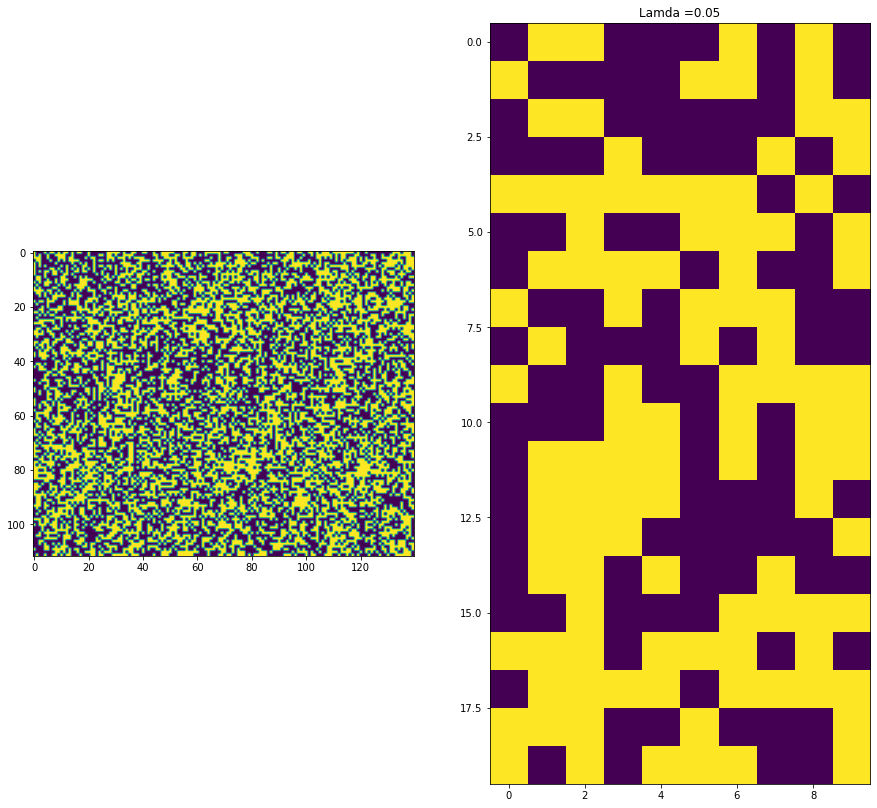

In [69]:
plt.rcParams['figure.figsize'] =(15, 20)
a = net[0].mean.data.flatten().cpu()
a = t.where(a>0, 1, 0)
b = net[1].mean.data.flatten().cpu()
b = t.where(b>0, 1, 0)
a = a.reshape(112, -1)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(a)
ax2.imshow(b.reshape(20, 10))
plt.title("Lamda ={}".format(lam))
plt.show()


In [70]:
lam = 0.1
layer_num = 2
prune_coefs = []
for l in range(layer_num):
    mu = net[l].mean
    sigma = t.exp(net[l].log_sigma) 
    res = t.abs(mu/sigma).cpu().detach().numpy()    
    prune_coefs.append(res)

for l in range(layer_num):
    prune_coef = prune_coefs[l]
    ids = (prune_coef <= lam) 
    net[l].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))  

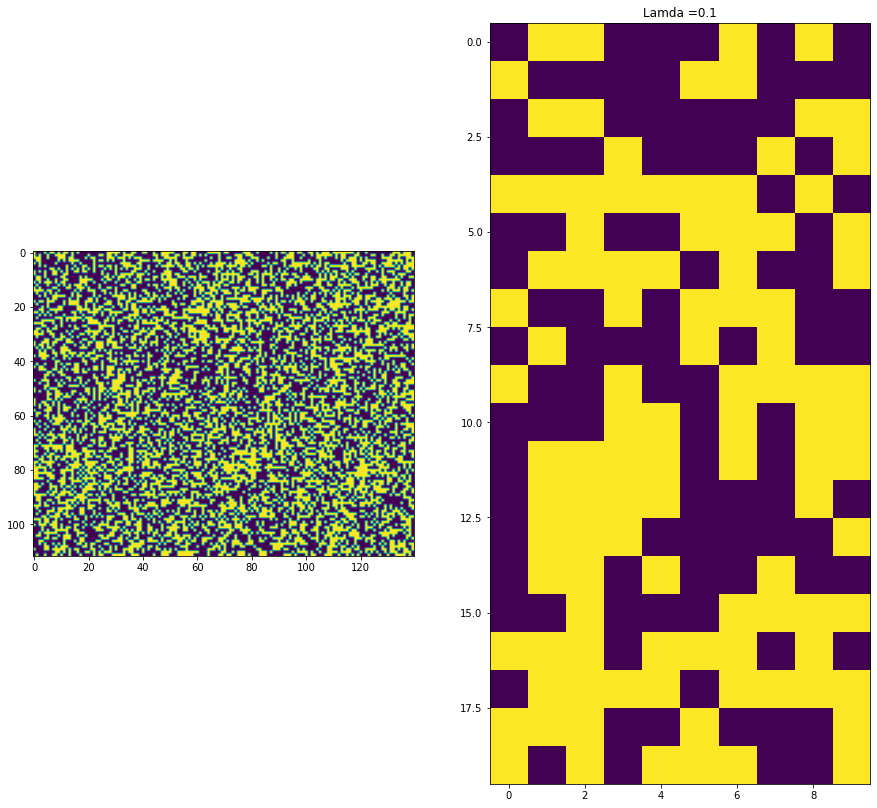

In [72]:
a = net[0].mean.data.flatten().cpu()
a = t.where(a>0, 1, 0)
b = net[1].mean.data.flatten().cpu()
b = t.where(b>0, 1, 0)
a = a.reshape(112, -1)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(a)
ax2.imshow(b.reshape(20, 10))
plt.title("Lamda ={}".format(lam))
plt.show()


In [73]:
lam = 0.2
layer_num = 2
prune_coefs = []
for l in range(layer_num):
    mu = net[l].mean
    sigma = t.exp(net[l].log_sigma) 
    res = t.abs(mu/sigma).cpu().detach().numpy()    
    prune_coefs.append(res)

for l in range(layer_num):
    prune_coef = prune_coefs[l]
    ids = (prune_coef <= lam) 
    net[l].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))  

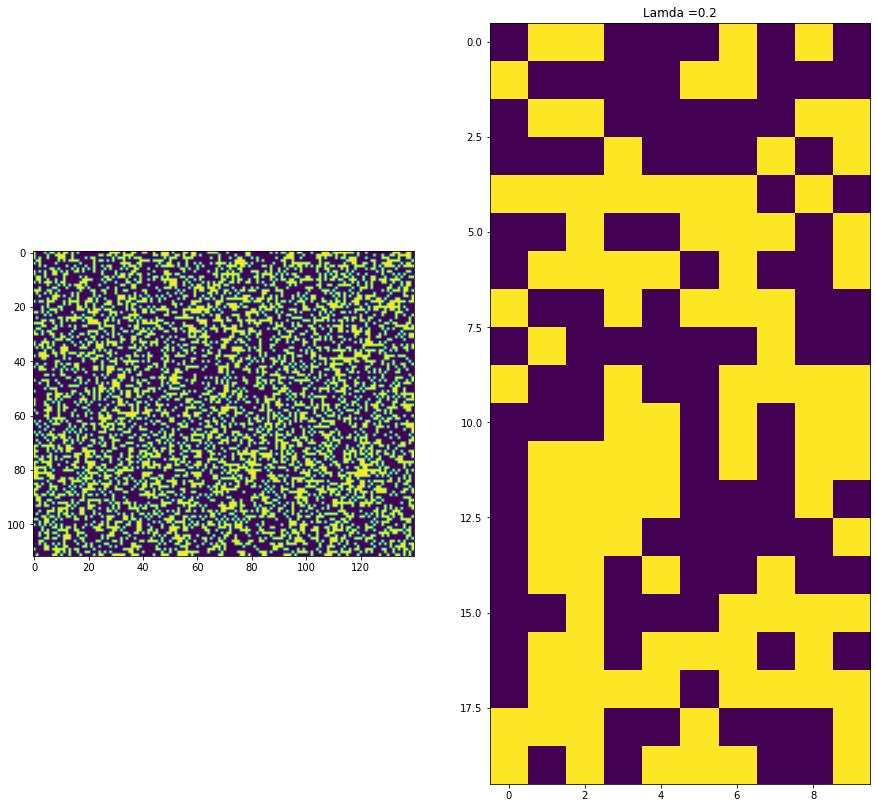

In [74]:
a = net[0].mean.data.flatten().cpu()
a = t.where(a>0, 1, 0)
b = net[1].mean.data.flatten().cpu()
b = t.where(b>0, 1, 0)
a = a.reshape(112, -1)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(a)
ax2.imshow(b.reshape(20, 10))
plt.title("Lamda ={}".format(lam))
plt.show()

In [75]:
lam = 0.5
layer_num = 2
prune_coefs = []
for l in range(layer_num):
    mu = net[l].mean
    sigma = t.exp(net[l].log_sigma) 
    res = t.abs(mu/sigma).cpu().detach().numpy()    
    prune_coefs.append(res)

for l in range(layer_num):
    prune_coef = prune_coefs[l]
    ids = (prune_coef <= lam) 
    net[l].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))  

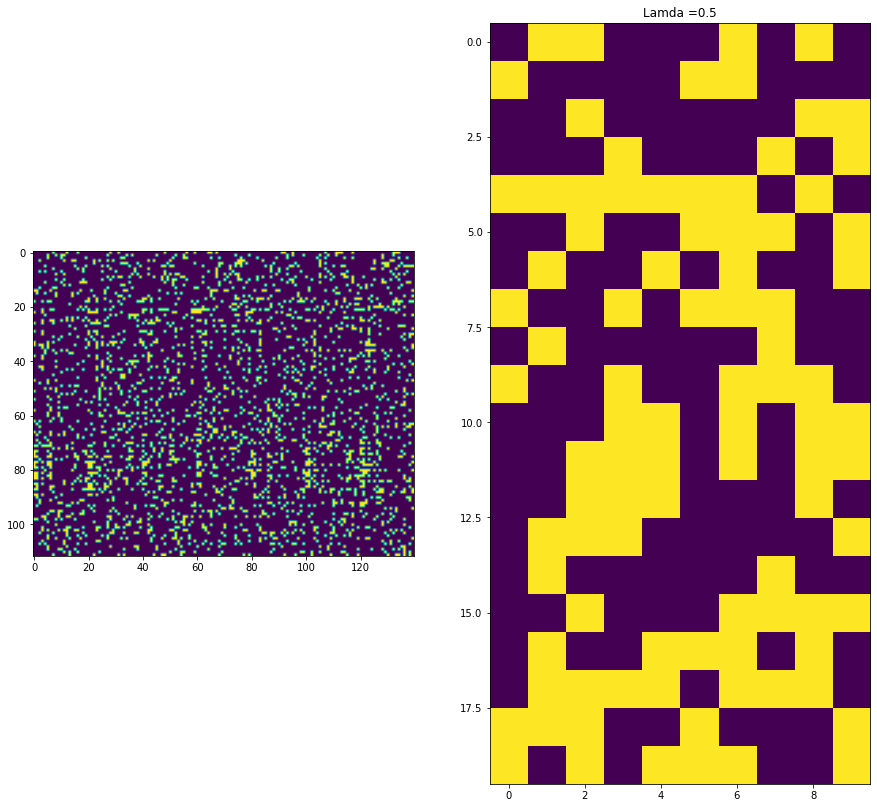

In [76]:
a = net[0].mean.data.flatten().cpu()
a = t.where(a>0, 1, 0)
b = net[1].mean.data.flatten().cpu()
b = t.where(b>0, 1, 0)
a = a.reshape(112, -1)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(a)
ax2.imshow(b.reshape(20, 10))
plt.title("Lamda ={}".format(lam))
plt.show()

In [77]:
lam = 1
layer_num = 2
prune_coefs = []
for l in range(layer_num):
    mu = net[l].mean
    sigma = t.exp(net[l].log_sigma) 
    res = t.abs(mu/sigma).cpu().detach().numpy()    
    prune_coefs.append(res)

for l in range(layer_num):
    prune_coef = prune_coefs[l]
    ids = (prune_coef <= lam) 
    net[l].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))  

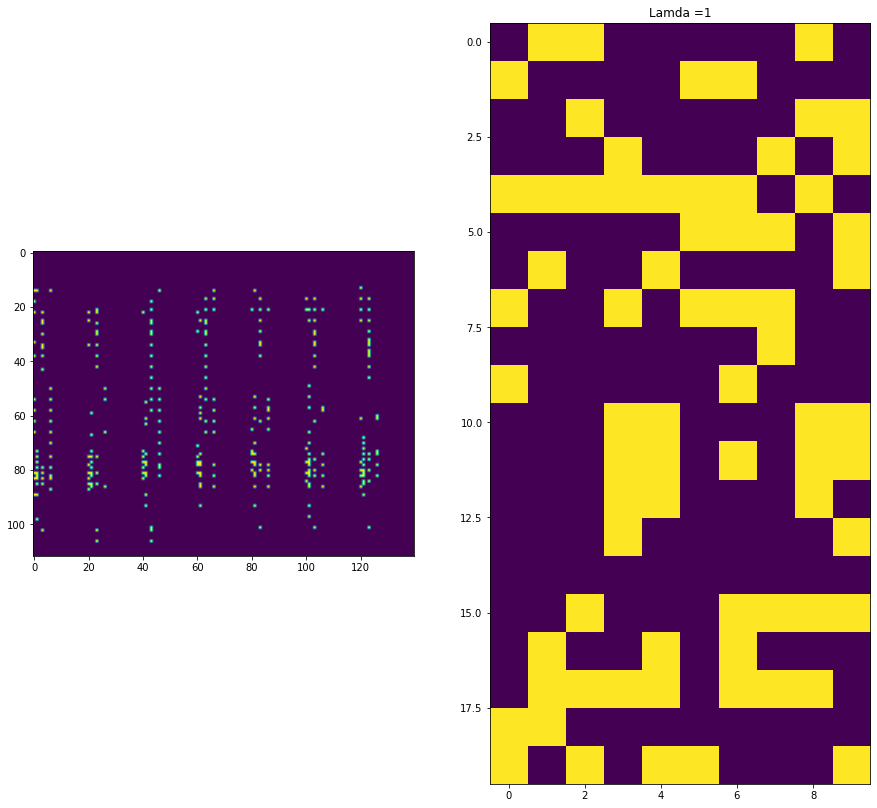

In [78]:
a = net[0].mean.data.flatten().cpu()
a = t.where(a>0, 1, 0)
b = net[1].mean.data.flatten().cpu()
b = t.where(b>0, 1, 0)
a = a.reshape(112, -1)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(a)
ax2.imshow(b.reshape(20, 10))
plt.title("Lamda ={}".format(lam))
plt.show()


In [79]:
lam = 2
layer_num = 2
prune_coefs = []
for l in range(layer_num):
    mu = net[l].mean
    sigma = t.exp(net[l].log_sigma) 
    res = t.abs(mu/sigma).cpu().detach().numpy()    
    prune_coefs.append(res)

for l in range(layer_num):
    prune_coef = prune_coefs[l]
    ids = (prune_coef <= lam) 
    net[l].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))  

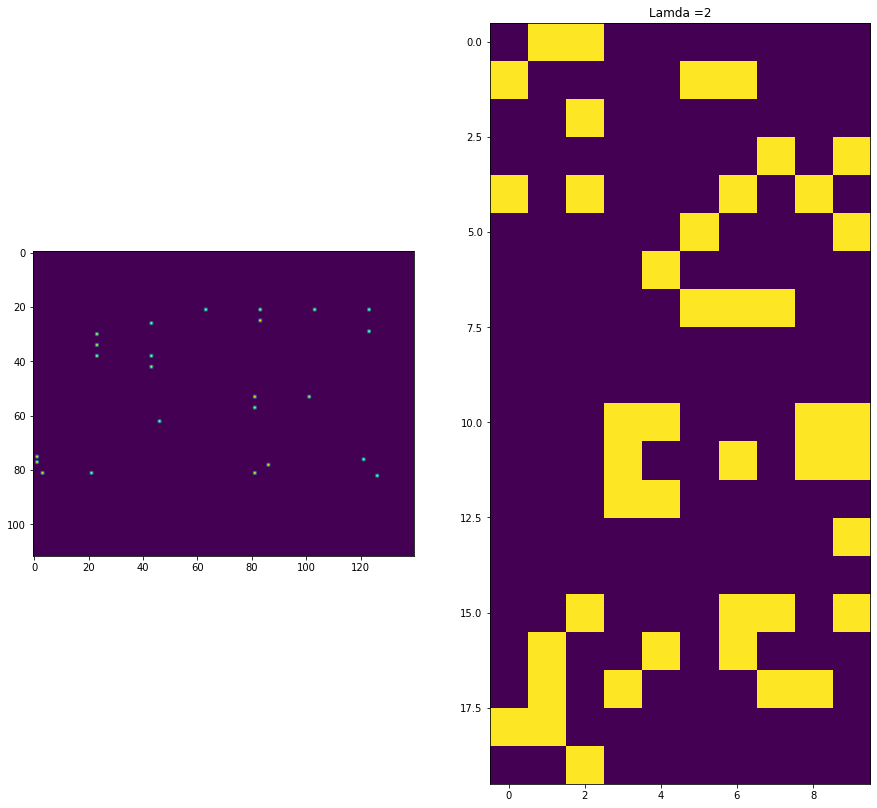

In [80]:
a = net[0].mean.data.flatten().cpu()
a = t.where(a>0, 1, 0)
b = net[1].mean.data.flatten().cpu()
b = t.where(b>0, 1, 0)
a = a.reshape(112, -1)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(a)
ax2.imshow(b.reshape(20, 10))
plt.title("Lamda ={}".format(lam))
plt.show()


Выаод достаточно прост: в статье приведен действительно хороший критерий для удаления параметров, так как при увеличении трешхолда мы наблюдаем заметное сокращение числа параметров. Результаты приблизительно повторили графики из статьи, что тоже не может не радовать.